In [2]:
# imports
import numpy as np
import statsmodels.formula.api as smf
from boxoffice.modeling.cleaned_data import X_train, y_train, X_test, y_test
from sklearn.metrics import root_mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns

MOVIES_DB_PATH: boxoffice/db/data/data.sqlite
MOVIES_DB_PATH: ../boxoffice/db/data/data.sqlite
movies.csv exists, 1731906929.6094918, 1731906849.873322
Reading from movies.csv
Index([], dtype='object')


In [3]:
# add the new variables to the data
X_train['opening_wide_revenue'] = y_train
X_test['opening_wide_revenue'] = y_test
X_train['log_opening_wide_revenue'] = np.log(y_train)
X_test['log_opening_wide_revenue'] = np.log(y_test)
X_train['sqrt_opening_wide_revenue'] = np.sqrt(y_train)
X_test['sqrt_opening_wide_revenue'] = np.sqrt(y_test)
X_train['log_budget'] = np.log(X_train['budget'])
X_test['log_budget'] = np.log(X_test['budget'])
X_train['sqrt_budget'] = np.sqrt(X_train['budget'])
X_test['sqrt_budget'] = np.sqrt(X_test['budget'])
X_train['sqrt_wikipedia_pre_release_cumulative_views'] = np.sqrt(X_train['wikipedia_pre_release_cumulative_views'])
X_test['sqrt_wikipedia_pre_release_cumulative_views'] = np.sqrt(X_test['wikipedia_pre_release_cumulative_views'])
X_train['log_wikipedia_pre_release_cumulative_views'] = np.log(X_train['wikipedia_pre_release_cumulative_views'] + 1)
X_test['log_wikipedia_pre_release_cumulative_views'] = np.log(X_test['wikipedia_pre_release_cumulative_views'] + 1)
X_train['sqrt_top_5_trailer_views'] = np.sqrt(X_train['top_5_trailer_views'])
X_test['sqrt_top_5_trailer_views'] = np.sqrt(X_test['top_5_trailer_views'])
X_train['log_top_5_trailer_views'] = np.log(X_train['top_5_trailer_views'])
X_test['log_top_5_trailer_views'] = np.log(X_test['top_5_trailer_views'])
X_train['not_friday_opener'] = X_train['release_day_of_week_non_preview'] != 4
X_test['not_friday_opener'] = X_test['release_day_of_week_non_preview'] != 4

# within production method, change the stop motion to be called digital animation
X_train['production_method'] = X_train['production_method'].replace('Stop-Motion Animation', 'Digital Animation')
X_test['production_method'] = X_test['production_method'].replace('Stop-Motion Animation', 'Digital Animation')


/tmp/ipykernel_12117/4046168135.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['opening_wide_revenue'] = y_test
/tmp/ipykernel_12117/4046168135.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['log_opening_wide_revenue'] = np.log(y_test)
/tmp/ipykernel_12117/4046168135.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmen

In [3]:
# # write all movies with a log wikipedia pre release cumulative views of less than -5 to a txt
# with open('low_wikipedia_pre_release_cumulative_views.txt', 'w') as f:
#     for index, row in X_train.iterrows():
#         if row['log_wikipedia_pre_release_cumulative_views'] < 2:
#             f.write(f'{row['wikipedia_key']}\n')
#     for index, row in X_test.iterrows():
#         if row['log_wikipedia_pre_release_cumulative_views'] < 2:
#             f.write(f'{row['wikipedia_key']}\n')

In [12]:
# print all columns that start with production_method
print([col for col in X_train.columns if col.startswith("production_method")])

# formula = "opening_wide_revenue ~ 0 + top_5_trailer_views + budget : production_method + wikipedia_pre_release_cumulative_views + wikipedia_pre_release_cumulative_views :  metacritic_before_wide_friday_calculated : in_franchise : production_method"
formula = "opening_wide_revenue ~ 0 + top_5_trailer_views + budget + wikipedia_pre_release_cumulative_views + wikipedia_pre_release_cumulative_views :  production_method : in_franchise"
formula = "opening_wide_revenue ~ 0 + top_5_trailer_views + budget + wikipedia_pre_release_monday_views : in_franchise : production_method"

# "metacritic_review_count",
# "metacritic_score_calculated",
# "metacritic_monday_before_wide_friday_calculated",
# "metacritic_before_wide_friday_calculated",
# "metacritic_before_first_day_calculated"

# add in the interactions
model_simple_glm = smf.glm(formula=formula, data=X_train).fit()

pred_simple_glm = model_simple_glm.predict(X_test)

# pred_simple_glm = np.exp(pred_simple_glm)
# pred_simple_glm = pred_simple_glm ** 2

print("RMSE:", root_mean_squared_error(y_test, pred_simple_glm))
print(model_simple_glm.summary())

train_pred = model_simple_glm.predict(X_train)
# train_pred = np.exp(train_pred)
# train_pred = train_pred ** 2

# print predictions vs actual within training data
training_data = pd.DataFrame(
    {
        "actual": y_train,
        "predicted": train_pred,
        "title": X_train["title"],
        "extra": X_train["sqrt_budget"],
    }
)

# write to a file
training_data.to_csv("training_data.csv")

fig = px.scatter(training_data, x="actual", y="predicted", hover_name="title", color="extra")
fig.add_trace(go.Scatter(x=training_data["actual"], y=training_data["actual"], mode="lines", name="y=x"))
fig.update_layout(title="Actual vs Predicted Opening Weekend Revenue", xaxis_title="Actual", yaxis_title="Predicted")

['production_method', 'production_method_Digital_Animation', 'production_method_Live_Action', 'production_method_Stop_Motion_Animation']
RMSE: 22959807.98982813
                  Generalized Linear Model Regression Results                   
Dep. Variable:     opening_wide_revenue   No. Observations:                  677
Model:                              GLM   Df Residuals:                      672
Model Family:                  Gaussian   Df Model:                            4
Link Function:                 Identity   Scale:                      3.1973e+14
Method:                            IRLS   Log-Likelihood:                -12264.
Date:                  Tue, 19 Nov 2024   Deviance:                   2.1486e+17
Time:                          21:17:04   Pearson chi2:                 2.15e+17
No. Iterations:                       3   Pseudo R-squ. (CS):             0.9761
Covariance Type:              nonrobust                                         
                             

In [ ]:
# find best interaction term
possibilities = [
    "top_5_trailer_views",
    "budget",
    "wikipedia_pre_release_cumulative_views",
    "metacritic_before_wide_friday_calculated",
    "in_franchise",
    "production_method",
    "normalized_budget",
    "normalized_top_5_trailer_views",
    "normalized_wikipedia_pre_release_cumulative_views",
    "normalized_metacritic_before_wide_friday_calculated",
    "log_budget",
    "log_top_5_trailer_views",
    "log_wikipedia_pre_release_cumulative_views",
    "wikipedia_pre_release_monday_views",
    "genre",
    "source",
    "top_3_trailer_views",
    "max_trailer_views",
    "total_trailer_views",
    "sum_cast_box_office",
    "sum_crew_box_office",
    "mpaa_rating"
]

from itertools import combinations

basic_model = "opening_wide_revenue ~ 0 + top_5_trailer_views + budget + wikipedia_pre_release_cumulative_views"

best_3_interactions = []
best_rmse = 100000000000

for i in range(1, 4):
    for combo in combinations(possibilities, i):
        formula = basic_model + " + " + " : ".join(combo)
        model = smf.glm(formula=formula, data=X_train).fit()
        pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, pred)
        if rmse < best_rmse:
            best_3_interactions = combo
            best_rmse = rmse
            print(best_3_interactions, best_rmse)

print(best_3_interactions)

('top_5_trailer_views',) 27421054.718193922
('metacritic_before_wide_friday_calculated',) 27396621.0242101
('in_franchise',) 26679887.390754785
('production_method',) 25964555.9446219
('top_5_trailer_views', 'in_franchise') 25120028.875322152
('budget', 'production_method') 24618907.46758768
('wikipedia_pre_release_cumulative_views', 'in_franchise') 24426182.34173703
('wikipedia_pre_release_cumulative_views', 'production_method') 23637375.261868846
('budget', 'in_franchise', 'production_method') 23096233.230929025
('wikipedia_pre_release_cumulative_views', 'in_franchise', 'production_method') 21472287.968184467


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame({'title': X_test['title'], 'actual': y_test, 'predicted': pred_simple_glm, 'mpaa_rating': X_test['mpaa_rating'], 'creative_type': X_test['creative_type'], 'budget': X_test['budget'], 'wikipedia_pre_release_cumulative_views': X_test['wikipedia_pre_release_cumulative_views'], 'metacritic_before_wide_friday_calculated': X_test['metacritic_before_wide_friday_calculated'], 'genre': X_test['genre'], 'log_top_5_trailer_views': X_test['log_top_5_trailer_views'], 'sqrt_wikipedia_pre_release_cumulative_views': X_test['sqrt_wikipedia_pre_release_cumulative_views'], 'top_5_trailer_views': X_test['top_5_trailer_views'], 'log_budget': X_test['log_budget'], 'log_wikipedia_pre_release_cumulative_views': X_test['log_wikipedia_pre_release_cumulative_views'], 'log_top_5_trailer_views': X_test['log_top_5_trailer_views'], 'not_friday_opener': X_test['not_friday_opener'], 'production_method': X_test['production_method'], 'normalized_budget': X_test['normalized_budget'], 'normalized_wikipedia_pre_release_cumulative_views': X_test['normalized_wikipedia_pre_release_cumulative_views'], 'normalized_top_5_trailer_views': X_test['normalized_top_5_trailer_views'], 'normalized_metacritic_before_wide_friday_calculated': X_test['normalized_metacritic_before_wide_friday_calculated']})

# plot actual vs predicted
fig = px.scatter(results_df, x='actual', y='predicted', hover_name='title', color='log_budget')
fig.add_trace(go.Scatter(x=results_df['actual'], y=results_df['actual'], mode='lines', name='y=x'))
fig.update_layout(title='Actual vs Predicted Opening Weekend Revenue', xaxis_title='Actual', yaxis_title='Predicted')


In [ ]:
# plot residuals
results_df["residual"] = results_df["actual"] - results_df["predicted"]

fig2 = px.scatter(results_df, x="predicted", y="residual", hover_name="title", color="creative_type")
fig2.add_trace(go.Scatter(x=results_df["predicted"], y=[0] * len(results_df), mode="lines", name="y=0"))
fig2.update_layout(title="Residuals vs Predicted Opening Weekend Revenue", xaxis_title="Predicted", yaxis_title="Residual")

In [ ]:
# plot residuals as a percentage of actual
results_df["residual_percent_difference"] = (
    (results_df["actual"] - results_df["predicted"]) / ((results_df["actual"] + results_df["predicted"]) / 2)
)

results_df["log_actual"] = np.log(results_df["actual"])

fig2 = px.scatter(results_df, x="actual", y="residual_percent_difference", hover_name="title", color="log_actual", labels={"residual_percent_difference": "Residual Percent Difference", "predicted": "Predicted Opening Weekend Revenue", "actual": "Actual Opening Weekend Revenue"})

x_axis_length = int(max(results_df["predicted"]) * 1.05)
fig2.add_trace(go.Scatter(x=results_df["predicted"], y=[0] * len(results_df), mode="lines", name="y=0"))
max_abs_residual_percent_difference = max(abs(results_df["residual_percent_difference"]))
fig2.update_layout(
    title="Residuals Percent Difference vs Predicted Opening Weekend Revenue",
    xaxis_title="Predicted",
    yaxis_title="Residual Percent Difference",
    yaxis=dict(range=[-1.1 * max_abs_residual_percent_difference, 1.1 * max_abs_residual_percent_difference]),
    xaxis=dict(range=[0, x_axis_length])
)

# positive is under prediction, negative is over prediction

/tmp/ipykernel_35894/4292569314.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_35894/4292569314.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



,title,actual,predicted,budget,wikipedia_pre_release_cumulative_views,metacritic_before_wide_friday_calculated,top_5_trailer_views
468,Avengers: Endgame,357115007.0,20.092462,400000000.0,8078868.0,79.0,538068656.0
623,Spider-Man: No Way Home,260138569.0,19.223198,200000000.0,6211755.0,72.0,197038432.0
346,Avengers: Infinity War,257698183.0,19.612586,300000000.0,6361008.0,70.0,542667265.0
37,Star Wars Ep. VII: The Force Awakens,247966675.0,19.858331,533200000.0,7308580.0,80.0,191498815.0
294,Star Wars Ep. VIII: The Last Jedi,220009584.0,18.780880,262000000.0,3016480.0,83.0,65764078.0
96,Deadpool & Wolverine,211435291.0,18.369901,200000000.0,2957720.0,62.0,92496312.0
318,Black Panther,202003951.0,19.050303,200000000.0,3504158.0,86.0,158087866.0
496,The Lion King,191770759.0,18.070935,260000000.0,2164436.0,59.0,49977186.0
647,Doctor Strange in the Multiverse of Madness,187420998.0,18.464865,200000000.0,3534041.0,64.0,80431609.0
360,Incredibles 2,182687905.0,18.592015,200000000.0,898943.0,80.0,337879237.0


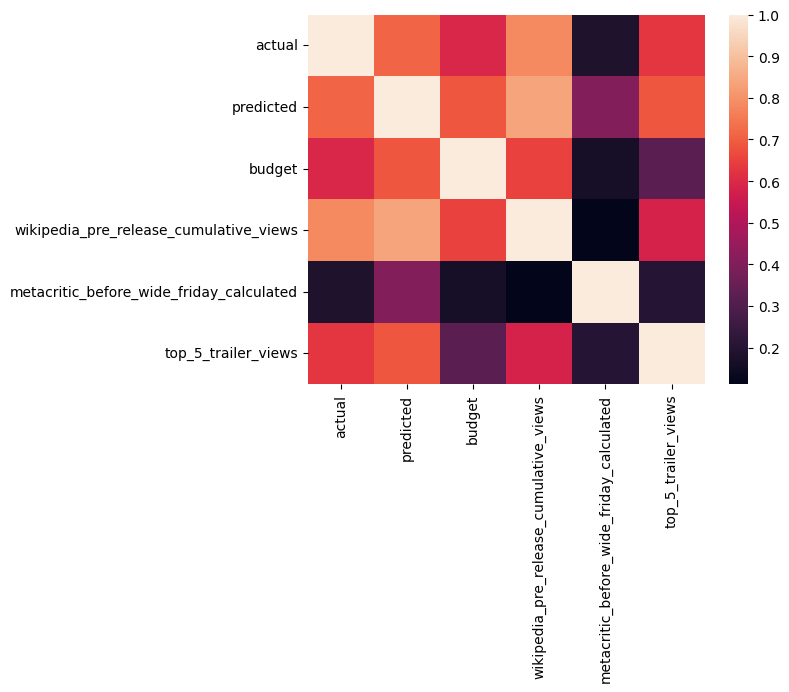

In [ ]:
# create a heatmap with the big movies and their various features
all_big_movies = pd.concat([X_train, X_test]).query('opening_wide_revenue > 100000000')

# add actual and predicted values
all_big_movies['actual'] = all_big_movies['opening_wide_revenue']
all_big_movies['predicted'] = model_simple_glm.predict(all_big_movies)

relevant_features = ['actual', 'predicted', 'budget', 'wikipedia_pre_release_cumulative_views', 'metacritic_before_wide_friday_calculated', 'top_5_trailer_views']

sns.heatmap(all_big_movies[relevant_features].corr())

display_features = ['title', 'actual', 'predicted', 'budget', 'wikipedia_pre_release_cumulative_views', 'metacritic_before_wide_friday_calculated', 'top_5_trailer_views']

# create a table of the big movies and their values
all_big_movies[display_features].sort_values('actual', ascending=False)